In [1]:
import pickle
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from ast import literal_eval
from model.loss import Pairwise_ranking_loss
from model.drmm import Gen_DRMM_Model
from model.pacrr import Gen_PACRR_Model
from model.pacrr_drmm import Gen_PACRR_DRMM_Model
from model.callback import LossHistory, _metric
from utility.utility import ndcg, mAP_score, highlight, history_plot, generate_pairwise_dataset
from IPython.core.display import display, HTML
from tqdm.notebook import tqdm

pd.options.mode.chained_assignment = None

display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 99)
pd.set_option('display.max_rows', 50)

%matplotlib inline

In [2]:
test = pd.read_csv('./data/paccr_drmm_bert_test_all.csv', converters={"query_idf"          : literal_eval,
                                                                      "idf_softmax"        : literal_eval,
                                                                      "sim_matrix"         : literal_eval,
                                                                      "query_token"        : literal_eval,
                                                                      "product_title_token": literal_eval,
                                                                      "token_ids"          : literal_eval,
                                                                      "drmm_hist"          : literal_eval,
                                                                      'token'              : literal_eval})
test['binary_relevance'] = test['median_relevance'].apply(lambda x: 0 if x <= 2 else 1) 

In [3]:
df = generate_pairwise_dataset(test)
df.reset_index(inplace=True, drop=True)

In [4]:
dev_q = set(random.sample(list(df['query'].unique()), 50))
train_q = set(df['query'].unique()) - dev_q
with open('./data/dev_q.pkl', 'wb') as f:
    pickle.dump(dev_q, f)

In [5]:
with open('./data/dev_q.pkl', 'rb') as f:
    dev_q = pickle.load(f)
train_q = set(df['query'].unique()) - dev_q

In [6]:
train = df[df['query'].isin(train_q)]
dev = df[df['query'].isin(dev_q)]
test = test[test['query'].isin(dev_q)]
test.rename(columns={'drmm_hist':'hist'}, inplace=True)

In [7]:
firstk = 13
lq = 8
lg = 5
nf = 32
ns = 2

In [8]:
metadata = {'negative_sim_matrix': tf.constant(train['sim_matrix_N'].tolist(), dtype=tf.float32, name='negative_sim_matrix'), 
            'positive_sim_matrix': tf.constant(train['sim_matrix_P'].tolist(), dtype=tf.float32, name='positive_sim_matrix'),
            'idf_softmax'        : tf.constant(train['idf_softmax'].tolist(), dtype=tf.float32, name='idf_softmax'),
            'query_idf'          : tf.ragged.constant(train['query_idf'], dtype=tf.float32, ragged_rank=1, name='query_idf'),
            'positive_hist'      : tf.ragged.constant(train['drmm_hist_P'], dtype=tf.float32, ragged_rank=1, name='positive_hist'),
            'negative_hist'      : tf.ragged.constant(train['drmm_hist_N'], dtype=tf.float32, ragged_rank=1, name='negative_hist')}

In [9]:
metadata_dev = {'negative_sim_matrix': tf.constant(dev['sim_matrix_N'].tolist(), dtype=tf.float32, name='negative_sim_matrix'),
                'positive_sim_matrix': tf.constant(dev['sim_matrix_P'].tolist(), dtype=tf.float32, name='positive_sim_matrix'),
                'idf_softmax'        : tf.constant(dev['idf_softmax'].tolist(), dtype=tf.float32, name='idf_softmax'),
                'query_idf'          : tf.ragged.constant(dev['query_idf'], dtype=tf.float32, ragged_rank=1, name='query_idf'),
                'positive_hist'      : tf.ragged.constant(dev['drmm_hist_P'], dtype=tf.float32, ragged_rank=1, name='positive_hist'),
                'negative_hist'      : tf.ragged.constant(dev['drmm_hist_N'], dtype=tf.float32, ragged_rank=1, name='negative_hist')}

In [10]:
tf.keras.backend.clear_session()
drmm = Gen_DRMM_Model(bert=True)
drmm.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=.1), loss=Pairwise_ranking_loss)

history_drmm = LossHistory(metadata_dev)
drmm_metric = _metric(test)

total_epoch_count = 100
batch_size = 128
drmm.fit(x=metadata, y=tf.constant([0.]*len(train)),
         validation_data=(metadata_dev, tf.constant([0.]*len(dev))),
         shuffle=True,
         epochs=total_epoch_count,
         batch_size=batch_size,
         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                    history_drmm,
                    drmm_metric])

Epoch 1/100


C:\Users\kwon\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


647/647 [==============================] - 41s 63ms/step - loss: 1.0002 - val_loss: 1.0001
Epoch 2/100
647/647 [==============================] - 25s 38ms/step - loss: 0.9999 - val_loss: 0.9998
Epoch 3/100
647/647 [==============================] - 28s 44ms/step - loss: 0.9994 - val_loss: 0.9993
Epoch 4/100
647/647 [==============================] - 25s 38ms/step - loss: 0.9990 - val_loss: 0.9990
Epoch 5/100
647/647 [==============================] - 27s 42ms/step - loss: 0.9987 - val_loss: 0.9988
Epoch 6/100
647/647 [==============================] - 26s 40ms/step - loss: 0.9985 - val_loss: 0.9987
Epoch 7/100
647/647 [==============================] - 25s 38ms/step - loss: 0.9984 - val_loss: 0.9986
Epoch 8/100
647/647 [==============================] - 30s 47ms/step - loss: 0.9983 - val_loss: 0.9985
Epoch 9/100
647/647 [==============================] - 20s 31ms/step - loss: 0.9983 - val_loss: 0.9985
Epoch 10/100
647/647 [==============================] - 25s 39ms/step - loss: 0.9982 

Epoch 40/100
647/647 [==============================] - 27s 41ms/step - loss: 0.9979 - val_loss: 0.9983
Epoch 41/100
647/647 [==============================] - 27s 42ms/step - loss: 0.9979 - val_loss: 0.9983
Epoch 42/100
647/647 [==============================] - 22s 34ms/step - loss: 0.9979 - val_loss: 0.9983
Epoch 43/100
647/647 [==============================] - 27s 41ms/step - loss: 0.9979 - val_loss: 0.9983
Epoch 44/100
647/647 [==============================] - 23s 36ms/step - loss: 0.9978 - val_loss: 0.9983
Epoch 45/100
647/647 [==============================] - 27s 42ms/step - loss: 0.9978 - val_loss: 0.9983
Epoch 46/100
647/647 [==============================] - 29s 45ms/step - loss: 0.9978 - val_loss: 0.9983
Epoch 47/100
647/647 [==============================] - 16s 25ms/step - loss: 0.9978 - val_loss: 0.9983
Epoch 48/100
647/647 [==============================] - 16s 24ms/step - loss: 0.9978 - val_loss: 0.9983
Epoch 49/100
647/647 [==============================] - 14s 22ms

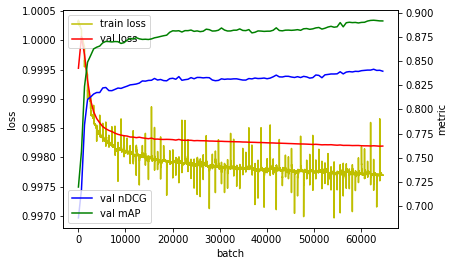

In [12]:
history_plot(history_drmm, drmm_metric, batch_size, df=train)

In [13]:
pacrr = Gen_PACRR_Model(firstk, lq, lg, nf, ns, bert=True)
pacrr.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=.1),
              loss=Pairwise_ranking_loss)

history_pacrr = LossHistory(metadata_dev)
pacrr_metric = _metric(test)

total_epoch_count = 100
batch_size = 1024
pacrr.fit(x=metadata, y=tf.constant([0.]*len(train)), 
          validation_data=(metadata_dev, tf.constant([0.]*len(dev))),
          shuffle=True,
          epochs=total_epoch_count,
          batch_size=batch_size,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                     history_pacrr,
                     pacrr_metric])

Epoch 1/100
81/81 [==============================] - 143s 2s/step - loss: 0.9899 - val_loss: 0.9737
Epoch 2/100
81/81 [==============================] - 183s 2s/step - loss: 0.9211 - val_loss: 0.8193
Epoch 3/100
81/81 [==============================] - 145s 2s/step - loss: 0.7925 - val_loss: 0.7991
Epoch 4/100
81/81 [==============================] - 138s 2s/step - loss: 0.7669 - val_loss: 0.7926
Epoch 5/100
81/81 [==============================] - 132s 2s/step - loss: 0.7547 - val_loss: 0.7894
Epoch 6/100
81/81 [==============================] - 148s 2s/step - loss: 0.7460 - val_loss: 0.7820
Epoch 7/100
81/81 [==============================] - 134s 2s/step - loss: 0.7396 - val_loss: 0.7725
Epoch 8/100
81/81 [==============================] - 133s 2s/step - loss: 0.7326 - val_loss: 0.7715
Epoch 9/100
81/81 [==============================] - 131s 2s/step - loss: 0.7251 - val_loss: 0.7690
Epoch 10/100
81/81 [==============================] - 133s 2s/step - loss: 0.7242 - val_loss: 0.7795

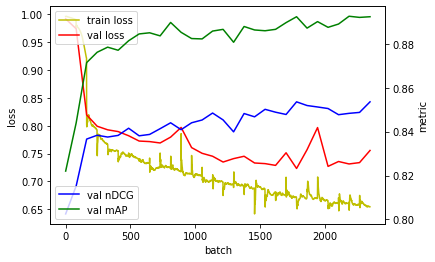

In [15]:
history_plot(history_pacrr, pacrr_metric, batch_size=batch_size, df=train)

In [16]:
pacrr_drmm = Gen_PACRR_DRMM_Model(firstk, lq, lg, nf, ns, bert=True)
pacrr_drmm.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=.005), loss=Pairwise_ranking_loss)

history_pacrr_drmm = LossHistory(metadata_dev)
pacrr_drmm_metric = _metric(test)
total_epoch_count = 100
batch_size = 128
pacrr_drmm.fit(x=metadata, y=tf.constant([0.]*len(train)),
               validation_data=(metadata_dev, tf.constant([0.]*len(dev))),
               shuffle=True,
               epochs=total_epoch_count,
               batch_size=batch_size,
               callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                          history_pacrr_drmm,
                          pacrr_drmm_metric])

Epoch 1/100
647/647 [==============================] - 156s 242ms/step - loss: 0.9454 - val_loss: 0.8549
Epoch 2/100
647/647 [==============================] - 194s 300ms/step - loss: 0.7590 - val_loss: 0.7513
Epoch 3/100
647/647 [==============================] - 176s 272ms/step - loss: 0.7086 - val_loss: 0.7313
Epoch 4/100
647/647 [==============================] - 171s 264ms/step - loss: 0.6893 - val_loss: 0.7229
Epoch 5/100
647/647 [==============================] - 165s 254ms/step - loss: 0.6755 - val_loss: 0.7170
Epoch 6/100
647/647 [==============================] - 171s 264ms/step - loss: 0.6644 - val_loss: 0.7126
Epoch 7/100
647/647 [==============================] - 163s 252ms/step - loss: 0.6555 - val_loss: 0.7115
Epoch 8/100
647/647 [==============================] - 162s 251ms/step - loss: 0.6487 - val_loss: 0.7111
Epoch 9/100
647/647 [==============================] - 161s 249ms/step - loss: 0.6428 - val_loss: 0.7095
Epoch 10/100
647/647 [==============================] -

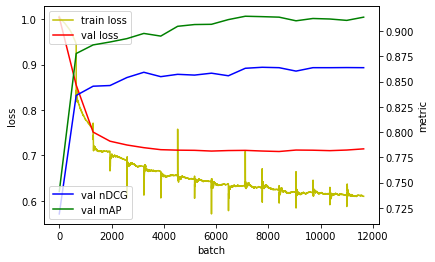

In [18]:
history_plot(history_pacrr_drmm, pacrr_drmm_metric, batch_size=128, df=train)

In [19]:
drmm_weight = drmm.get_weights()
with open('./model_weights/drmm_bert_weight.pkl', 'wb') as f:
    pickle.dump(drmm_weight, f)

pacrr_weight = pacrr.get_weights()
with open('./model_weights/pacrr_bert_weight.pkl', 'wb') as f:
    pickle.dump(pacrr_weight, f)

pacrr_drmm_weight = pacrr_drmm.get_weights()
with open('./model_weights/pacrr_drmm_bert_weight.pkl', 'wb') as f:
    pickle.dump(pacrr_drmm_weight, f)

In [20]:
# tf.keras.backend.clear_session()
# drmm = Gen_DRMM_Model(bert=True)
# with open('./model_weights/drmm_bert_weight.pkl', 'rb') as f:
#     drmm_weights = pickle.load(f) 
# drmm.set_weights(drmm_weights)

# pacrr = Gen_PACRR_Model(firstk, lq, lg, nf, ns, bert=True)
# with open('./model_weights/pacrr_bert_weight.pkl', 'rb') as f:
#     pacrr_weights = pickle.load(f)
# pacrr.set_weights(pacrr_weights)

# pacrr_drmm = Gen_PACRR_DRMM_Model(firstk, lq, lg, nf, ns, bert=True)
# with open('./model_weights/pacrr_drmm_bert_weight.pkl', 'rb') as f:
#     pacrr_drmm_weights = pickle.load(f)
# pacrr_drmm.set_weights(pacrr_drmm_weights)

In [21]:
# ndcg_test = test[test['query'] == random.sample(dev_q, 1)[0]]
ndcg_test = test[test['query'] == 'nike shoes']

metadata_ndcg = {'negative_sim_matrix' : tf.constant(ndcg_test['sim_matrix'].tolist(), dtype=tf.float32, name='negative_sim_matrix'),
                 'positive_sim_matrix' : tf.constant(ndcg_test['sim_matrix'].tolist(), dtype=tf.float32, name='positive_sim_matrix'),
                 'idf_softmax'         : tf.constant(ndcg_test['idf_softmax'].tolist(), dtype=tf.float32, name='idf_softmax'),
                 'query_idf'           : tf.ragged.constant(ndcg_test['query_idf'], dtype=tf.float32, ragged_rank=1, name='query_idf'),
                 'positive_hist'       : tf.ragged.constant(ndcg_test['hist'], dtype=tf.float32, ragged_rank=1, name='positive_hist'),
                 'negative_hist'       : tf.ragged.constant(ndcg_test['hist'], dtype=tf.float32, ragged_rank=1, name='negative_hist')}

ndcg_test.insert(5, 'rel_drmm', drmm.predict(metadata_ndcg)[:len(ndcg_test)], True)
ndcg_test.insert(5, 'rel_pacrr', pacrr.predict(metadata_ndcg)[:len(ndcg_test)], True)
ndcg_test.insert(5, 'rel_pacrr_drmm', pacrr_drmm.predict(metadata_ndcg)[:len(ndcg_test)], True)

pacrr_drmm_pred = ndcg_test.sort_values(by=['rel_pacrr_drmm'], axis=0, ascending=False)[['query', 'product_title', 'median_relevance', 'rel_pacrr_drmm', 'rel_pacrr', 'rel_drmm']]
print('nDCG : ', ndcg(pacrr_drmm_pred.median_relevance.values-1, form='exp'))
print('mAP : ', mAP_score([1 if i>2 else 0 for i in pacrr_drmm_pred.median_relevance.values]))
pacrr_drmm_pred.style.apply(highlight, axis=1).set_properties(subset=['query', "product_title"], **{'text-align': 'left'}).hide_index()

nDCG :  0.9349591894187718
mAP :  0.802426804765713


query,product_title,median_relevance,rel_pacrr_drmm,rel_pacrr,rel_drmm
nike shoes,Nike Women's Lunar Duet Classic Golf Shoes,4,0.729423,0.698974,-0.018592
nike shoes,Nike Men's SolarSoft Golf Grill Room Flat Gold/Black Shoes,4,0.714066,0.443354,-0.003059
nike shoes,Nike Junior's Range Jr Golf Shoes,4,0.664598,0.772595,-0.009954
nike shoes,Nike 653483 Hyperdunk 2014 TB Men's Basketball Shoes Size 7 1/2,2,0.623914,0.026034,0.005222
nike shoes,"Dr. Scholl's - Men's Michael Air-Pillo Gel Velcro Shoes, Wide Width",2,0.611840,0.561346,0.011107
nike shoes,Nike Mens Lunar Mont Royal Spikeless Golf Shoes,4,0.611840,0.561346,0.011107
nike shoes,Nike Ladies Lunar Duet Sport Golf Shoes,4,0.524238,0.177556,-0.009714
nike shoes,Nike Womens Lunar Duet Sport Blue/ White/ Thistle Golf Shoes,4,0.498084,-0.058154,0.008262
nike shoes,Nike Mens Lunar Cypress Spikeless Golf Shoes,4,0.412610,0.435328,-0.029855
nike shoes,Nike Son Of Force Mid Basketball Shoes New/Display,4,0.326573,0.332860,-0.010486


In [22]:
pacrr_pred = ndcg_test.sort_values(by=['rel_pacrr'], axis=0, ascending=False)[['query', 'product_title', 'median_relevance', 'rel_pacrr_drmm', 'rel_pacrr', 'rel_drmm']]
print('nDCG : ', ndcg(pacrr_pred.median_relevance.values-1, form='exp'))
print('mAP : ', mAP_score([1 if i>2 else 0 for i in pacrr_pred.median_relevance.values]))
pacrr_pred.style.apply(highlight, axis=1).set_properties(subset=['query', "product_title"], **{'text-align': 'left'}).hide_index()

nDCG :  0.94242665347697
mAP :  0.85559606138466


query,product_title,median_relevance,rel_pacrr_drmm,rel_pacrr,rel_drmm
nike shoes,Nike Junior's Range Jr Golf Shoes,4,0.664598,0.772595,-0.009954
nike shoes,Nike Women's Lunar Duet Classic Golf Shoes,4,0.729423,0.698974,-0.018592
nike shoes,"Dr. Scholl's - Men's Michael Air-Pillo Gel Velcro Shoes, Wide Width",2,0.611840,0.561346,0.011107
nike shoes,Nike Mens Lunar Mont Royal Spikeless Golf Shoes,4,0.611840,0.561346,0.011107
nike shoes,Nike Wild Trail Womens Running Shoes,4,0.079138,0.553821,0.004248
nike shoes,Nike Golf TW '14 Men's Grey/ Black Golf Shoes,4,0.079138,0.553821,0.004248
nike shoes,NIKE Men's Lunar Swingtip Suede Anthracite/Brickhouse Golf Shoes,3,0.319323,0.530053,0.020375
nike shoes,Nike Free 5.0 Womens Training Shoes - BlueDark GreyLime,4,0.319323,0.530053,0.020375
nike shoes,Nike Men's SolarSoft Golf Grill Room Flat Gold/Black Shoes,4,0.714066,0.443354,-0.003059
nike shoes,Nike Mens Lunar Cypress Spikeless Golf Shoes,4,0.412610,0.435328,-0.029855


In [23]:
drmm_pred = ndcg_test.sort_values(by=['rel_drmm'], axis=0, ascending=False)[['query', 'product_title', 'median_relevance', 'rel_pacrr_drmm', 'rel_pacrr', 'rel_drmm']]
print('nDCG : ', ndcg(drmm_pred.median_relevance.values-1, form='exp'))
print('mAP : ', mAP_score([1 if i>2 else 0 for i in drmm_pred.median_relevance.values]))
drmm_pred.style.apply(highlight, axis=1).set_properties(subset=['query', "product_title"], **{'text-align': 'left'}).hide_index()

nDCG :  0.8776429785864209
mAP :  0.8261779841848492


query,product_title,median_relevance,rel_pacrr_drmm,rel_pacrr,rel_drmm
nike shoes,NIKE Men's Lunar Swingtip Suede Anthracite/Brickhouse Golf Shoes,3,0.319323,0.530053,0.020375
nike shoes,Nike Free 5.0 Womens Training Shoes - BlueDark GreyLime,4,0.319323,0.530053,0.020375
nike shoes,Nike Benassi Swoosh Mens Sport Sandals Shoe,3,0.010963,0.351236,0.011255
nike shoes,Nike Men's Reax TR Iii SL Training Shoes (Black / Gray) - 12.0 D,4,0.010963,0.351236,0.011255
nike shoes,"Dr. Scholl's - Men's Michael Air-Pillo Gel Velcro Shoes, Wide Width",2,0.611840,0.561346,0.011107
nike shoes,Nike Mens Lunar Mont Royal Spikeless Golf Shoes,4,0.611840,0.561346,0.011107
nike shoes,Nike Oceania Nm Womens Sneakers Shoes,4,-0.268745,0.100484,0.010973
nike shoes,Nike Womens Lunar Duet Sport Blue/ White/ Thistle Golf Shoes,4,0.498084,-0.058154,0.008262
nike shoes,Nike 653483 Hyperdunk 2014 TB Men's Basketball Shoes Size 7 1/2,2,0.623914,0.026034,0.005222
nike shoes,Nike Wild Trail Womens Running Shoes,4,0.079138,0.553821,0.004248
